# Importar librerias

In [2]:
import janitor
import matplotlib.pyplot as plt
import missingno
import nhanes.load
import numpy as np
import pandas as pd
import scipy.stats
import seaborn as sns
import session_info
import sklearn.compose
import sklearn.impute
import sklearn.preprocessing
import statsmodels.api as sm
import statsmodels.datasets
import statsmodels.formula.api as smf

from sklearn.ensemble import RandomForestRegressor
from sklearn.experimental import enable_iterative_imputer
from sklearn.kernel_approximation import Nystroem
from sklearn.linear_model import BayesianRidge, Ridge
from sklearn.neighbors import KNeighborsRegressor
from statsmodels.graphics.mosaicplot import mosaic

d:\david\learning_platzi\dataScientistPython\datos_faltantes_imputacion\venv\Lib\site-packages\nhanes\load.py:5: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  import pkg_resources
d:\david\learning_platzi\dataScientistPython\datos_faltantes_imputacion\venv\Lib\site-packages\pkg_resources\__init__.py:3147: DeprecationWarning: Deprecated call to `pkg_resources.declare_namespace('zope')`.
Implementing implicit namespace packages (as specified in PEP 420) is preferred to `pkg_resources.declare_namespace`. See https://setuptools.pypa.io/en/latest/references/keywords.html#keyword-namespace-packages
  declare_namespace(pkg)
d:\david\learning_platzi\dataScientistPython\datos_faltantes_imputacion\venv\Lib\site-packages\pkg_resources\__init__.py:3147: DeprecationWarning: Deprecated call to `pkg_resources.declare_namespace('zope')`.
Implementing implicit namespace packages (as specified in PEP 420) is preferred to `pkg_res

## Importar funciones personalizadas

In [3]:
%run pandas-missing-extension.ipynb

## Cargar los datos de NHANES

In [4]:
nhanes_raw_df = nhanes.load.load_NHANES_data(year="2017-2018")
nhanes_raw_df

,GeneralHealthCondition,EverBreastfedOrFedBreastmilk,AgeStoppedBreastfeedingdays,AgeFirstFedFormuladays,AgeStoppedReceivingFormuladays,AgeStartedOtherFoodbeverage,AgeFirstFedMilkdays,TypeOfMilkFirstFedWholeMilk,TypeOfMilkFirstFed2Milk,TypeOfMilkFirstFed1Milk,...,DaysSmokedCigsDuringPast30Days,AvgCigarettesdayDuringPast30Days,TriedToQuitSmoking,TimesStoppedSmokingCigarettes,HowLongWereYouAbleToStopSmoking,UnitOfMeasureDayweekmonthyear_2_SMQ,CurrentSelfreportedHeightInches,CurrentSelfreportedWeightPounds,TriedToLoseWeightInPastYear,TimesLost10LbsOrMoreToLoseWeight
SEQN,,,,,,,,,,,,,,,,,,,,,
93703.0,NaN,1.0,273.0,1.0,365.0,152.0,365.0,Whole or regular milk,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
93704.0,NaN,1.0,60.0,3.0,365.0,126.0,365.0,Whole or regular milk,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
93705.0,Good,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,63.0,165.0,0.0,11 times or more
93706.0,Very good,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,68.0,145.0,0.0,Never
93707.0,Good,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
102952.0,Very good,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,117.0,0.0,Never
102953.0,Fair or,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,65.0,218.0,0.0,Never
102954.0,Good,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,66.0,150.0,0.0,Never


In [5]:
missing_values = nhanes_raw_df.isna().sum()
print(missing_values)

GeneralHealthCondition                 2402
EverBreastfedOrFedBreastmilk           7297
AgeStoppedBreastfeedingdays            7504
AgeFirstFedFormuladays                 7289
AgeStoppedReceivingFormuladays         7475
                                       ... 
UnitOfMeasureDayweekmonthyear_2_SMQ    7870
CurrentSelfreportedHeightInches        2590
CurrentSelfreportedWeightPounds        2538
TriedToLoseWeightInPastYear            3279
TimesLost10LbsOrMoreToLoseWeight       2572
Length: 197, dtype: int64


## Procesar los datos de NHANES

In [6]:
nhanes_df = (
    nhanes_raw_df.select_columns(
        "GeneralHealthCondition",
        "AgeInYearsAtScreening",
        "Gender",
        "CurrentSelfreportedHeightInches",
        "CurrentSelfreportedWeightPounds",
        "DoctorToldYouHaveDiabetes",
        "60SecPulse30SecPulse2",
        "TotalCholesterolMgdl"
    )
    .rename_columns(
        {
            "AgeInYearsAtScreening":"age",
            "CurrentSelfreportedHeightInches":"height",
            "CurrentSelfreportedWeightPounds":"weight",
            "DoctorToldYouHaveDiabetes":"diabetes",
            "60SecPulse30SecPulse2":"pulse",
            "TotalCholesterolMgdl":"total_cholesterol",
            "GeneralHealthCondition":"general_health_condition",
            "Gender": "gender"
        }
    )
    .replace(
        {
            "height": {
                9999: np.nan,
                7777: np.nan
            },
            "weight": {
                9999: np.nan,
                7777: np.nan
            },
            "diabetes": {
                "Borderline": np.nan
            }
        }
    )
    .missing.sort_variables_by_missingness()
    .dropna(
        subset = ["diabetes"],
        how = "any"
    )
    .transform_column(
        column_name = "diabetes",
        function = lambda s: s.astype(int),
        elementwise = False
    )
)

d:\david\learning_platzi\dataScientistPython\datos_faltantes_imputacion\venv\Lib\site-packages\pandas_flavor\register.py:164: FutureWarning: This function will be deprecated in a 1.x release. Please use `jn.select` instead.
  return method(self._obj, *args, **kwargs)
d:\david\learning_platzi\dataScientistPython\datos_faltantes_imputacion\venv\Lib\site-packages\pandas_flavor\register.py:164: FutureWarning: This function will be deprecated in a 1.x release. Please use `pd.DataFrame.rename` instead.
  return method(self._obj, *args, **kwargs)


In [7]:
nhanes_df

,height,weight,general_health_condition,total_cholesterol,pulse,diabetes,gender,age
SEQN,,,,,,,,
93703.0,NaN,NaN,NaN,NaN,NaN,0,Female,2.0
93704.0,NaN,NaN,NaN,NaN,NaN,0,Male,2.0
93705.0,63.0,165.0,Good,157.0,52.0,0,Female,66.0
93706.0,68.0,145.0,Very good,148.0,82.0,0,Male,18.0
93707.0,NaN,NaN,Good,189.0,100.0,0,Male,13.0
...,...,...,...,...,...,...,...,...
102951.0,NaN,NaN,NaN,NaN,NaN,0,Male,4.0
102953.0,65.0,218.0,Fair or,182.0,78.0,0,Male,42.0
102954.0,66.0,150.0,Good,172.0,78.0,0,Female,41.0


## Visualizar los valores faltantes

<Axes: >

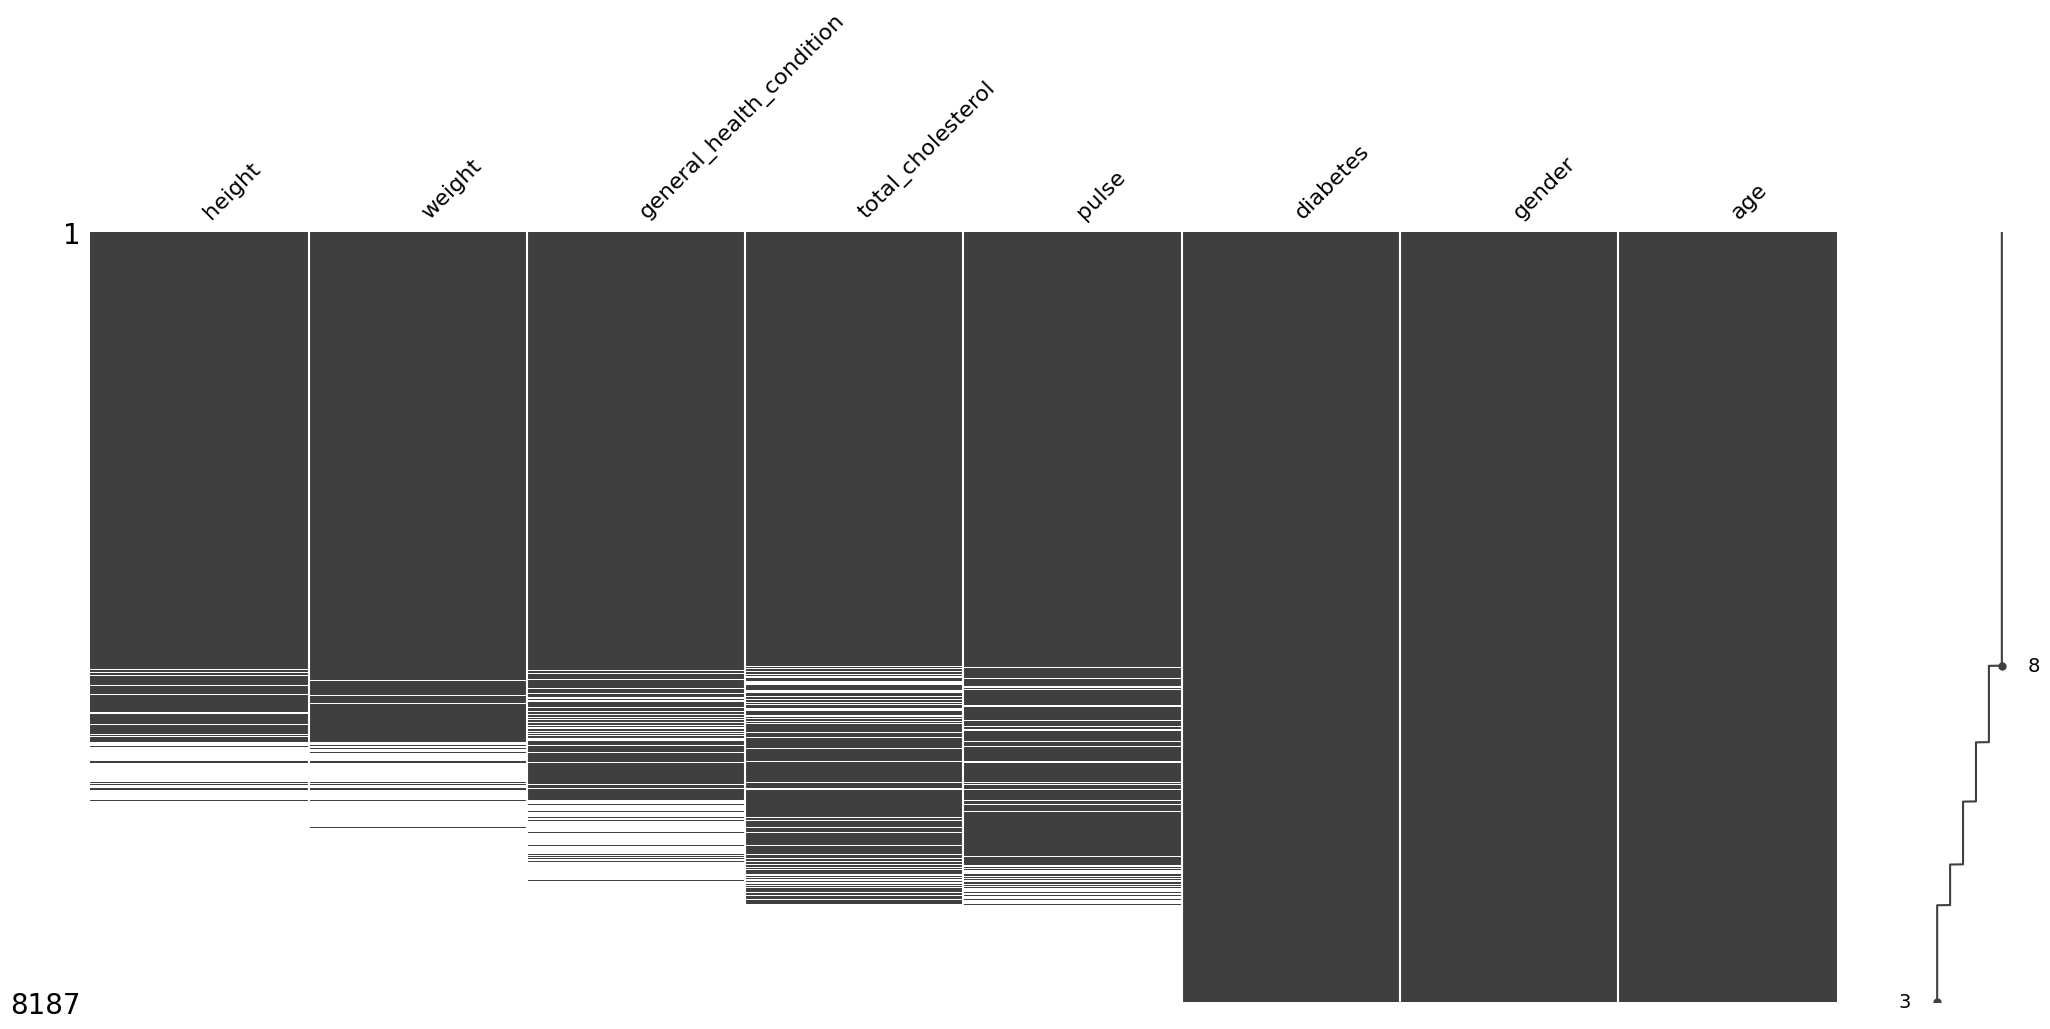

In [8]:
nhanes_df.missing.sort_variables_by_missingness().pipe(missingno.matrix, sort="descending")

d:\david\learning_platzi\dataScientistPython\datos_faltantes_imputacion\venv\Lib\site-packages\upsetplot\plotting.py:795: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  styles["linewidth"].fillna(1, inplace=True)
d:\david\learning_platzi\dataScientistPython\datos_faltantes_imputacion\venv\Lib\site-packages\upsetplot\plotting.py:796: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will nev

{'matrix': <Axes: >,
 'shading': <Axes: >,
 'totals': <Axes: >,
 'intersections': <Axes: ylabel='Intersection size'>}

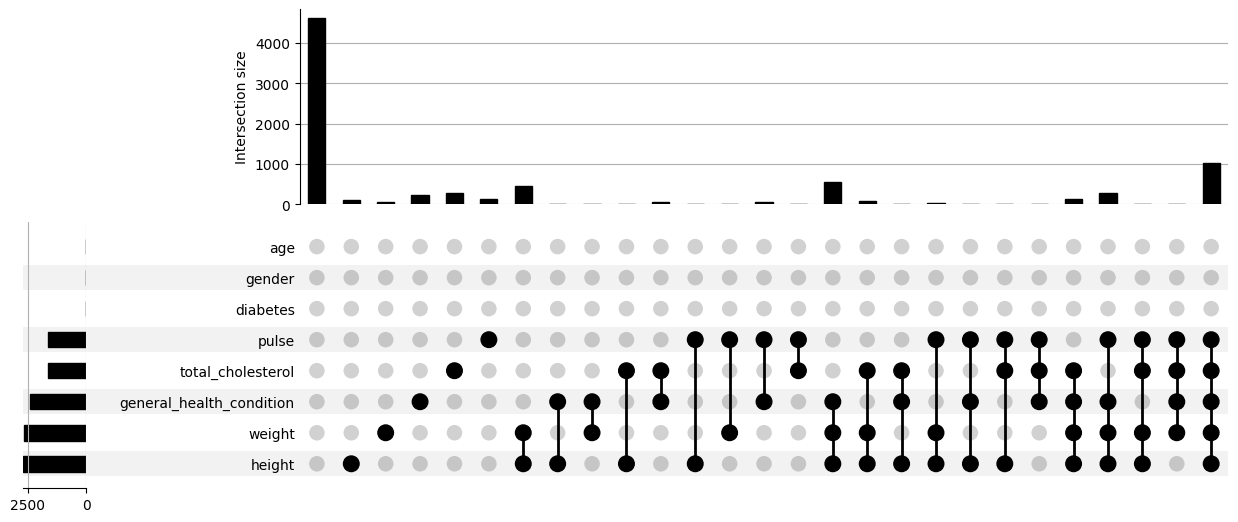

In [9]:
(
    nhanes_df
    .missing.sort_variables_by_missingness()
    .missing.missing_upsetplot()        
)

<Axes: >

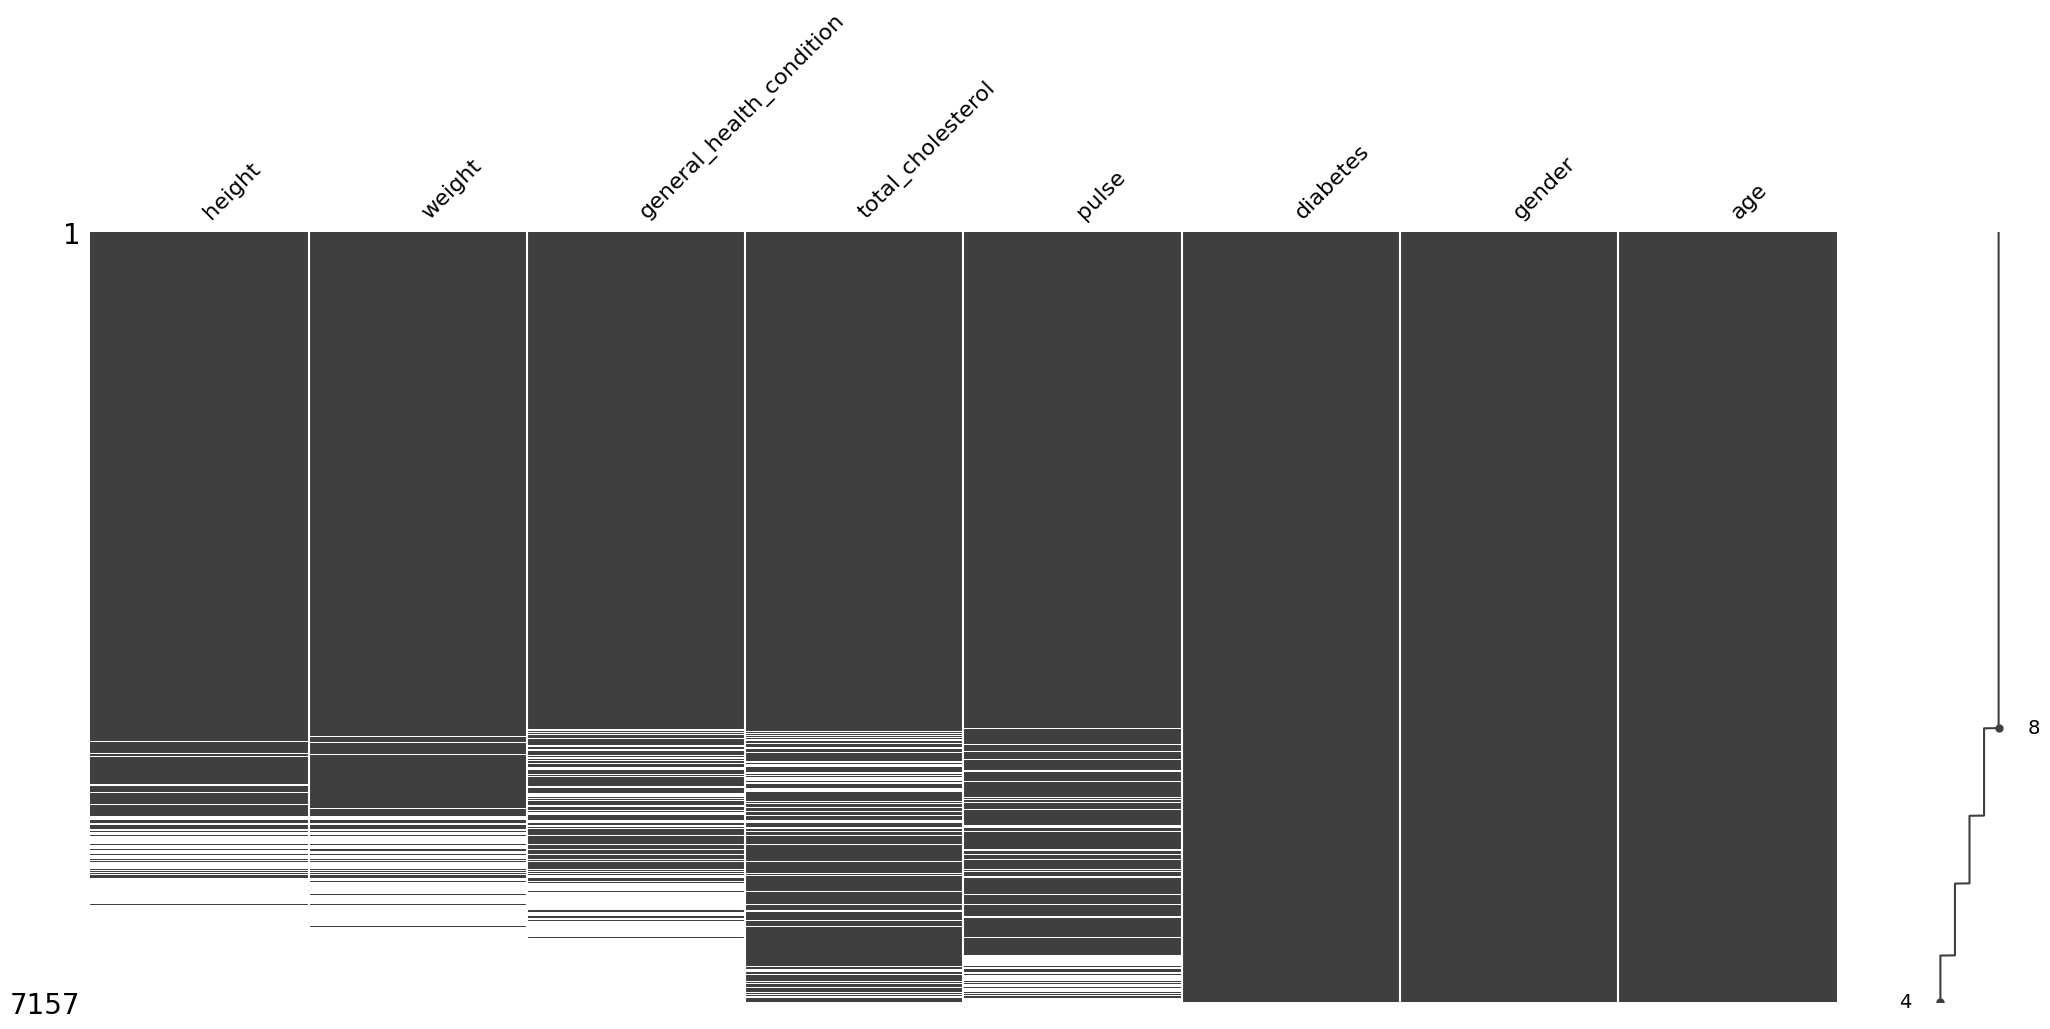

In [10]:
(
    nhanes_df.dropna(
        subset = ["pulse", "total_cholesterol", "general_health_condition", "weight", "height"],
        how = "all"
    )
    .missing.sort_variables_by_missingness()
    .pipe(missingno.matrix, sort="descending")
)

## Eliminar valores faltantes

In [11]:
nhanes_df = (
    nhanes_df.dropna(
        subset = ["pulse", "total_cholesterol", "general_health_condition", "weight", "height"],
        how = "all"
    )
    .missing.sort_variables_by_missingness()
)

nhanes_df.shape

(7157, 8)

## Consideracion y evaluacion de los distintos tipos de valores faltantes

In [12]:
female_weight, male_weight = (
    nhanes_df
    .select_columns("gender", "weight")
    .transform_column("weight", lambda x: x.isna(), elementwise = False)
    .groupby("gender")
    .weight
    .pipe(
        lambda df: (
            df.get_group("Female"),
            df.get_group("Male")
        )
    )
)

scipy.stats.ttest_ind(
    a = female_weight,
    b = male_weight,
    alternative = "two-sided"
)

d:\david\learning_platzi\dataScientistPython\datos_faltantes_imputacion\venv\Lib\site-packages\pandas_flavor\register.py:164: FutureWarning: This function will be deprecated in a 1.x release. Please use `jn.select` instead.
  return method(self._obj, *args, **kwargs)


TtestResult(statistic=np.float64(inf), pvalue=np.float64(nan), df=np.float64(-1.0))

## Ampliar el conjunto de herramientas para explorar valores faltantes

d:\david\learning_platzi\dataScientistPython\datos_faltantes_imputacion\venv\Lib\site-packages\pandas_flavor\register.py:164: FutureWarning: This function will be deprecated in a 1.x release. Please use `jn.select` instead.
  return method(self._obj, *args, **kwargs)


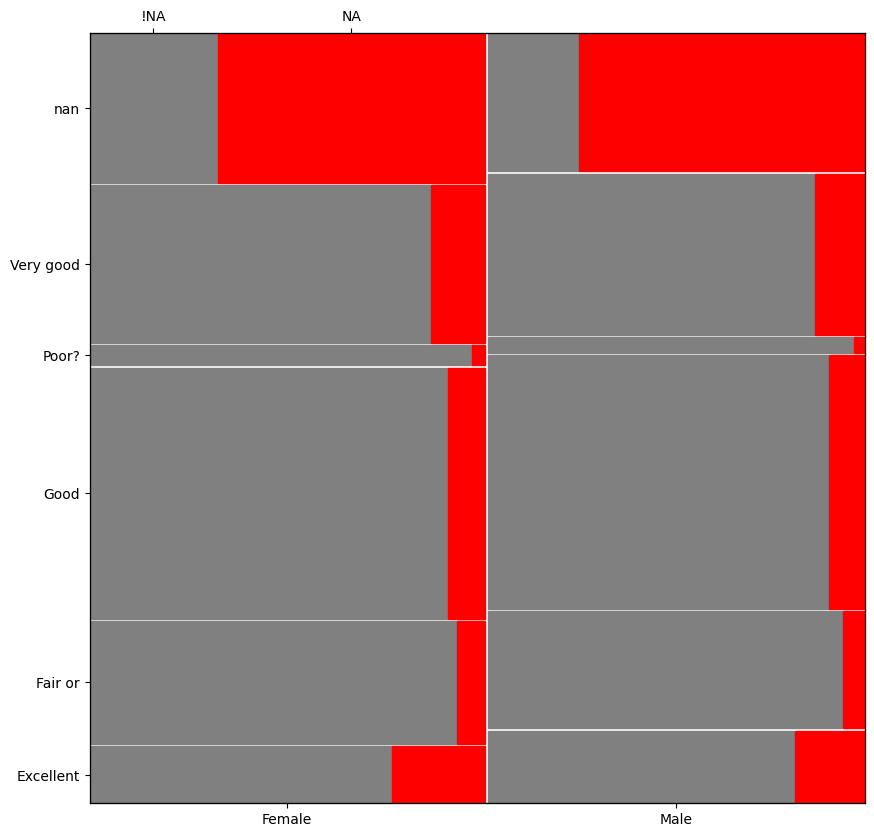

In [13]:
fig, ax = plt.subplots(figsize=(10,10))

(
    nhanes_df
    .select_columns('weight','general_health_condition','gender')
    .assign(
        weight=lambda df: df.weight.isna().replace([True, False], ['NA', '!NA'])
    )
    .groupby(
        ['gender','general_health_condition','weight'],
        dropna=False,
        as_index = True
    )
    .size()
    .pipe(
        lambda df: mosaic(
            data = df,
            properties=lambda key: {'color':'r' if 'NA' in key else 'gray'},
            horizontal=True,
            axes_label=True,
            title='',
            labelizer=lambda key: '',
            ax = ax
        )
    )
);

### Tratamiento de variables categoricas para imputacion de valores faltantes

In [14]:
nhanes_transformed_df = nhanes_df.copy(deep=True)

In [15]:
encoder = sklearn.preprocessing.OrdinalEncoder()

X = [["Male"], ["Female"], ["Female"]]
X

[['Male'], ['Female'], ['Female']]

In [16]:
encoder.fit_transform(X)

array([[1.],
       [0.],
       [0.]])

In [17]:
encoder.categories_

[array(['Female', 'Male'], dtype=object)]

In [18]:
encoder.inverse_transform([[1], [0], [0]])

array([['Male'],
       ['Female'],
       ['Female']], dtype=object)

#### Aplicando la codificacion ordinal a todas las variables categoricas de nhanes

In [19]:
categorical_columns = nhanes_df.select_dtypes(include=[object, "category"]).columns

In [20]:
categorical_transformer = sklearn.compose.make_column_transformer(
    (sklearn.preprocessing.OrdinalEncoder(), categorical_columns),
    remainder="passthrough"
)

In [21]:
nhanes_transformed_df = (
    pd.DataFrame(
        categorical_transformer.fit_transform(nhanes_df),
        columns = categorical_transformer.get_feature_names_out(),
        index = nhanes_df.index
    )
    .rename_columns(
        function = lambda x: x.removeprefix("ordinalencoder__")
    )
    .rename_columns(
        function = lambda x: x.removeprefix("remainder__")
    )
)

nhanes_transformed_df

d:\david\learning_platzi\dataScientistPython\datos_faltantes_imputacion\venv\Lib\site-packages\pandas_flavor\register.py:164: FutureWarning: This function will be deprecated in a 1.x release. Please use `pd.DataFrame.rename` instead.
  return method(self._obj, *args, **kwargs)


,general_health_condition,gender,height,weight,total_cholesterol,pulse,diabetes,age
SEQN,,,,,,,,
93705.0,2.0,0.0,63.0,165.0,157.0,52.0,0.0,66.0
93706.0,4.0,1.0,68.0,145.0,148.0,82.0,0.0,18.0
93707.0,2.0,1.0,NaN,NaN,189.0,100.0,0.0,13.0
93709.0,NaN,0.0,62.0,200.0,176.0,74.0,0.0,75.0
93711.0,4.0,1.0,69.0,142.0,238.0,62.0,0.0,56.0
...,...,...,...,...,...,...,...,...
102949.0,0.0,1.0,72.0,180.0,201.0,96.0,0.0,33.0
102953.0,1.0,1.0,65.0,218.0,182.0,78.0,0.0,42.0
102954.0,2.0,0.0,66.0,150.0,172.0,78.0,0.0,41.0


## One Hot Encoding 

In [22]:
nhanes_transformed_df2 = nhanes_df.copy(deep=True)

### pandas.get_dummies() vs sklearn.prepocessing.OneHotEncoder()
#### pandas.get_dummies()

In [23]:
(
    nhanes_transformed_df2
    .select_columns("general_health_condition")
    .pipe(pd.get_dummies)
)

d:\david\learning_platzi\dataScientistPython\datos_faltantes_imputacion\venv\Lib\site-packages\pandas_flavor\register.py:164: FutureWarning: This function will be deprecated in a 1.x release. Please use `jn.select` instead.
  return method(self._obj, *args, **kwargs)


,general_health_condition_Excellent,general_health_condition_Fair or,general_health_condition_Good,general_health_condition_Poor?,general_health_condition_Very good
SEQN,,,,,
93705.0,False,False,True,False,False
93706.0,False,False,False,False,True
93707.0,False,False,True,False,False
93709.0,False,False,False,False,False
93711.0,False,False,False,False,True
...,...,...,...,...,...
102949.0,True,False,False,False,False
102953.0,False,True,False,False,False
102954.0,False,False,True,False,False


#### sklearn.preprocessing.OneHotEncoder()

In [24]:
transformer = sklearn.compose.make_column_transformer(
    (sklearn.preprocessing.OrdinalEncoder(), ["gender"]),
    (sklearn.preprocessing.OneHotEncoder(), ["general_health_condition"]),
    remainder="passthrough"
)

In [25]:
nhanes_transformed_df2 = (
    pd.DataFrame(
        transformer.fit_transform(nhanes_df),
        columns = transformer.get_feature_names_out(),
        index = nhanes_df.index
    )
    .rename_columns(
        function = lambda x: x.removeprefix("ordinalencoder__")
    )
    .rename_columns(
        function = lambda x: x.removeprefix("remainder__")
    )
    .rename_columns(
        function = lambda x: x.removeprefix("onehotencoder__")
    )
)

nhanes_transformed_df2

d:\david\learning_platzi\dataScientistPython\datos_faltantes_imputacion\venv\Lib\site-packages\pandas_flavor\register.py:164: FutureWarning: This function will be deprecated in a 1.x release. Please use `pd.DataFrame.rename` instead.
  return method(self._obj, *args, **kwargs)


,gender,general_health_condition_Excellent,general_health_condition_Fair or,general_health_condition_Good,general_health_condition_Poor?,general_health_condition_Very good,general_health_condition_nan,height,weight,total_cholesterol,pulse,diabetes,age
SEQN,,,,,,,,,,,,,
93705.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,63.0,165.0,157.0,52.0,0.0,66.0
93706.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,68.0,145.0,148.0,82.0,0.0,18.0
93707.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,NaN,NaN,189.0,100.0,0.0,13.0
93709.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,62.0,200.0,176.0,74.0,0.0,75.0
93711.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,69.0,142.0,238.0,62.0,0.0,56.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
102949.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,72.0,180.0,201.0,96.0,0.0,33.0
102953.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,65.0,218.0,182.0,78.0,0.0,42.0
102954.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,66.0,150.0,172.0,78.0,0.0,41.0


In [26]:
(
    transformer
    .named_transformers_
    .get("onehotencoder")
    .categories_
)

[array(['Excellent', 'Fair or', 'Good', 'Poor?', 'Very good', nan],
       dtype=object)]

## Tipos de imputacion de valores faltantes

#### Imputacion de un unico valor (media, mediana, moda)

In [27]:
(
    nhanes_df
    .transform_column(
        "height",
        lambda x: x.fillna(x.mean()),
        elementwise = False
    )
    .height
    .mean()
)

np.float64(66.25655976676386)

d:\david\learning_platzi\dataScientistPython\datos_faltantes_imputacion\venv\Lib\site-packages\pandas_flavor\register.py:164: FutureWarning: This function will be deprecated in a 1.x release. Please use `jn.select` instead.
  return method(self._obj, *args, **kwargs)
d:\david\learning_platzi\dataScientistPython\datos_faltantes_imputacion\venv\Lib\site-packages\pandas_flavor\register.py:164: FutureWarning: This function will be deprecated in a 1.x release. Please use `jn.select` instead.
  return method(self._obj, *args, **kwargs)
d:\david\learning_platzi\dataScientistPython\datos_faltantes_imputacion\venv\Lib\site-packages\pandas_flavor\register.py:164: FutureWarning: This function will be deprecated in a 1.x release. Please use `jn.select` instead.
  return method(self._obj, *args, **kwargs)


Text(0.5, 1.0, 'Mode')

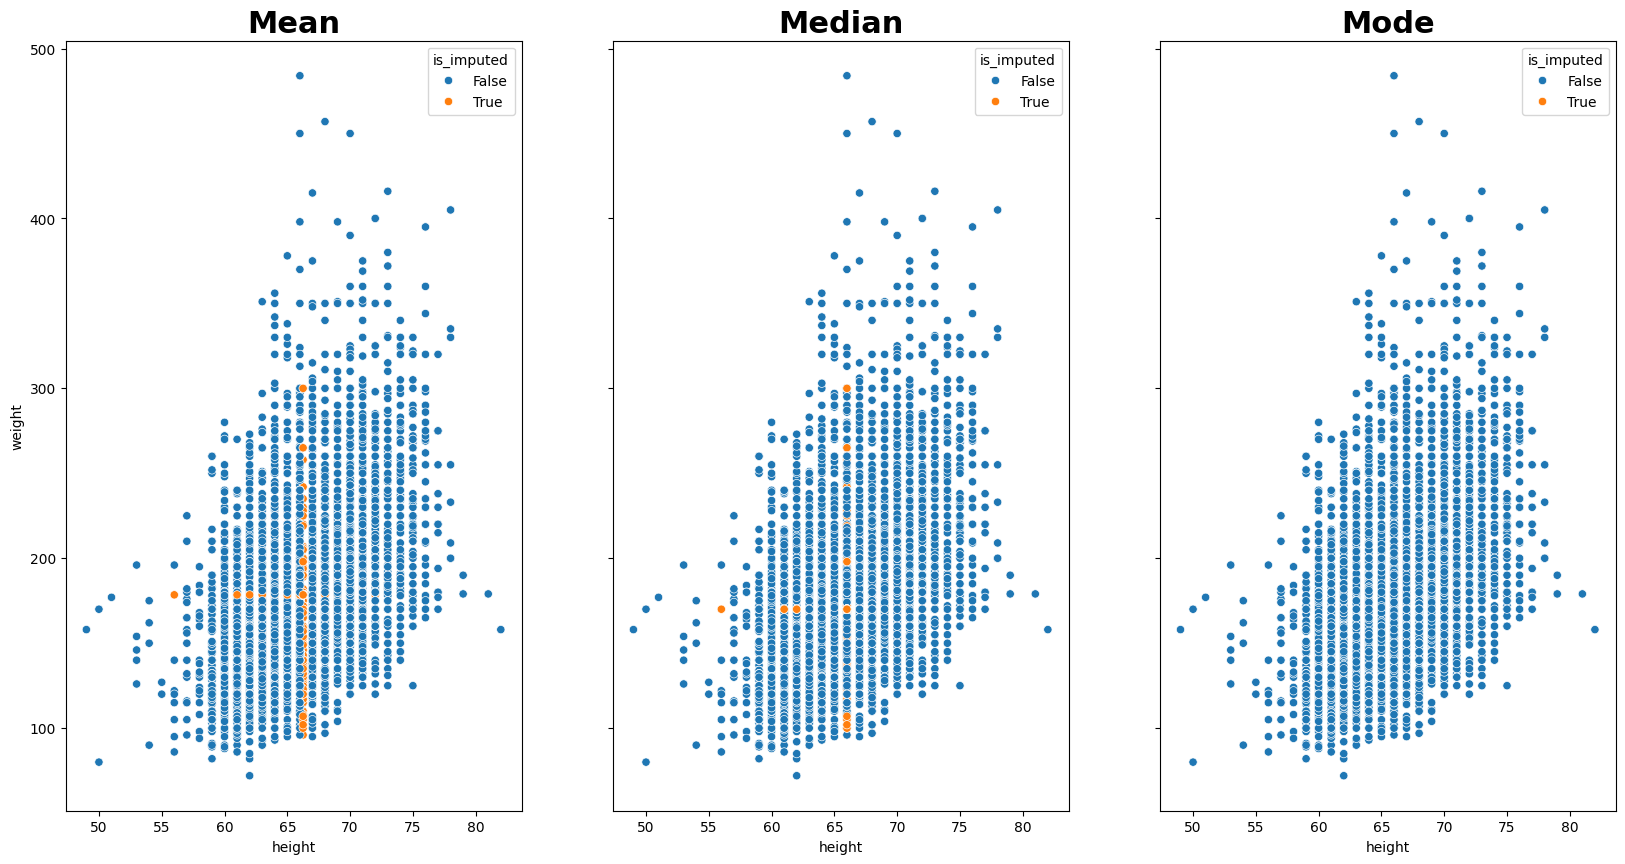

In [28]:
fig, ax = plt.subplots(1,3,figsize=(20,10), sharey=True)
(
    nhanes_df
    .select_columns("height", "weight")
    .missing.bind_shadow_matrix(True, False, suffix= "_imp")
    .assign(
        height = lambda df: df.height.fillna(value = df.height.mean()),
        weight = lambda df: df.weight.fillna(value = df.weight.mean())
    ).missing.scatter_imputation_plot(
        x="height",
        y="weight",
        # show_marginal = True,
        # height = 10,
        ax=ax[0]
    )
),
(
    nhanes_df
    .select_columns("height", "weight")
    .missing.bind_shadow_matrix(True, False, suffix= "_imp")
    .assign(
        height = lambda df: df.height.fillna(value = df.height.median()),
        weight = lambda df: df.weight.fillna(value = df.weight.median())
    ).missing.scatter_imputation_plot(
        x="height",
        y="weight",
        # show_marginal = True,
        # height = 10,
        ax=ax[1]
    )
),
(
    nhanes_df
    .select_columns("height", "weight")
    .missing.bind_shadow_matrix(True, False, suffix= "_imp")
    .assign(
        height = lambda df: df.height.fillna(value = df.height.mode()),
        weight = lambda df: df.weight.fillna(value = df.weight.mode())
    ).missing.scatter_imputation_plot(
        x="height",
        y="weight",
        # show_marginal = True,
        # height = 10,
        ax=ax[2]
    )
),
ax[0].set_title("Mean", fontsize =22, fontweight='bold')
ax[1].set_title("Median", fontsize =22, fontweight='bold')
ax[2].set_title("Mode", fontsize =22, fontweight='bold')

## Imputacion por llenado hacia atras e imputacion por llenado hacia adelante

#### fillna() vs ffill() o bfill()

In [29]:
(
    nhanes_df
    .select_columns("height", "weight")
    .fillna(method = "ffill")
)

d:\david\learning_platzi\dataScientistPython\datos_faltantes_imputacion\venv\Lib\site-packages\pandas_flavor\register.py:164: FutureWarning: This function will be deprecated in a 1.x release. Please use `jn.select` instead.
  return method(self._obj, *args, **kwargs)
C:\Users\david\AppData\Local\Temp\ipykernel_4148\3896394080.py:4: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  .fillna(method = "ffill")


,height,weight
SEQN,,
93705.0,63.0,165.0
93706.0,68.0,145.0
93707.0,68.0,145.0
93709.0,62.0,200.0
93711.0,69.0,142.0
...,...,...
102949.0,72.0,180.0
102953.0,65.0,218.0
102954.0,66.0,150.0


In [30]:
(
    nhanes_df
    .select_columns("height", "weight")
    .bfill()
)

d:\david\learning_platzi\dataScientistPython\datos_faltantes_imputacion\venv\Lib\site-packages\pandas_flavor\register.py:164: FutureWarning: This function will be deprecated in a 1.x release. Please use `jn.select` instead.
  return method(self._obj, *args, **kwargs)


,height,weight
SEQN,,
93705.0,63.0,165.0
93706.0,68.0,145.0
93707.0,62.0,200.0
93709.0,62.0,200.0
93711.0,69.0,142.0
...,...,...
102949.0,72.0,180.0
102953.0,65.0,218.0
102954.0,66.0,150.0


In [31]:
(
    nhanes_df
    .select_columns("height", "weight", "gender", "diabetes", "general_health_condition")
    .sort_values(
        by = ["gender", "diabetes", "general_health_condition", "height"],
        ascending = True
    )
    .transform_column(
        "weight",
        lambda x: x.ffill(),
        elementwise = False
    )
)

d:\david\learning_platzi\dataScientistPython\datos_faltantes_imputacion\venv\Lib\site-packages\pandas_flavor\register.py:164: FutureWarning: This function will be deprecated in a 1.x release. Please use `jn.select` instead.
  return method(self._obj, *args, **kwargs)


,height,weight,gender,diabetes,general_health_condition
SEQN,,,,,
94421.0,56.0,115.0,Female,0,Excellent
94187.0,59.0,130.0,Female,0,Excellent
95289.0,59.0,162.0,Female,0,Excellent
97967.0,59.0,130.0,Female,0,Excellent
99125.0,59.0,105.0,Female,0,Excellent
...,...,...,...,...,...
96561.0,74.0,290.0,Male,1,NaN
96954.0,NaN,175.0,Male,1,NaN
97267.0,NaN,175.0,Male,1,NaN


## Imputacion por algoritmo de vecinos mas cercanos (KNN)

In [32]:
nhanes_transformed_df

,general_health_condition,gender,height,weight,total_cholesterol,pulse,diabetes,age
SEQN,,,,,,,,
93705.0,2.0,0.0,63.0,165.0,157.0,52.0,0.0,66.0
93706.0,4.0,1.0,68.0,145.0,148.0,82.0,0.0,18.0
93707.0,2.0,1.0,NaN,NaN,189.0,100.0,0.0,13.0
93709.0,NaN,0.0,62.0,200.0,176.0,74.0,0.0,75.0
93711.0,4.0,1.0,69.0,142.0,238.0,62.0,0.0,56.0
...,...,...,...,...,...,...,...,...
102949.0,0.0,1.0,72.0,180.0,201.0,96.0,0.0,33.0
102953.0,1.0,1.0,65.0,218.0,182.0,78.0,0.0,42.0
102954.0,2.0,0.0,66.0,150.0,172.0,78.0,0.0,41.0


In [33]:
knn_imputer = sklearn.impute.KNNImputer()

nhanes_df_knn = nhanes_transformed_df.copy(deep=True)

nhanes_df_knn.iloc[:, :] = knn_imputer.fit_transform(nhanes_transformed_df).round()
nhanes_df_knn

,general_health_condition,gender,height,weight,total_cholesterol,pulse,diabetes,age
SEQN,,,,,,,,
93705.0,2.0,0.0,63.0,165.0,157.0,52.0,0.0,66.0
93706.0,4.0,1.0,68.0,145.0,148.0,82.0,0.0,18.0
93707.0,2.0,1.0,69.0,130.0,189.0,100.0,0.0,13.0
93709.0,2.0,0.0,62.0,200.0,176.0,74.0,0.0,75.0
93711.0,4.0,1.0,69.0,142.0,238.0,62.0,0.0,56.0
...,...,...,...,...,...,...,...,...
102949.0,0.0,1.0,72.0,180.0,201.0,96.0,0.0,33.0
102953.0,1.0,1.0,65.0,218.0,182.0,78.0,0.0,42.0
102954.0,2.0,0.0,66.0,150.0,172.0,78.0,0.0,41.0


<Axes: xlabel='height', ylabel='weight'>

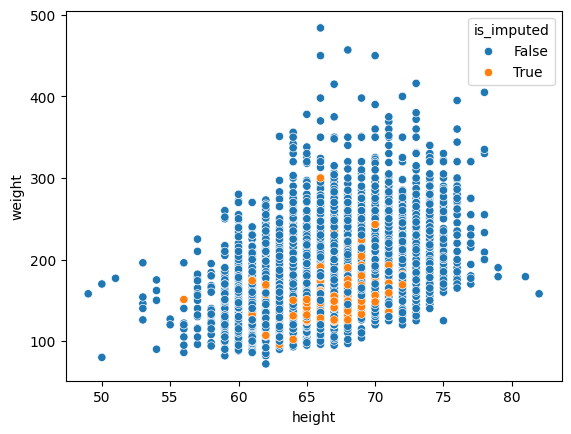

In [34]:
(
    pd.concat(
        [
            nhanes_df_knn,
            nhanes_df.missing.create_shadow_matrix(True, False, suffix= "_imp", only_missing=True)
        ],
        axis = 1
    )
    .missing.scatter_imputation_plot(
        x = "height",
        y = "weight"
    )
)

## Ordenamiento por cantidad de variables faltantes

In [35]:
knn_imputer = sklearn.impute.KNNImputer()

nhanes_df_knn = nhanes_transformed_df.missing.sort_variables_by_missingness(ascending=True).copy(deep=True)

nhanes_df_knn.iloc[:, :] = knn_imputer.fit_transform(nhanes_transformed_df.missing.sort_variables_by_missingness(ascending=True)).round()
nhanes_df_knn

,gender,age,diabetes,pulse,total_cholesterol,general_health_condition,weight,height
SEQN,,,,,,,,
93705.0,0.0,66.0,0.0,52.0,157.0,2.0,165.0,63.0
93706.0,1.0,18.0,0.0,82.0,148.0,4.0,145.0,68.0
93707.0,1.0,13.0,0.0,100.0,189.0,2.0,130.0,69.0
93709.0,0.0,75.0,0.0,74.0,176.0,2.0,200.0,62.0
93711.0,1.0,56.0,0.0,62.0,238.0,4.0,142.0,69.0
...,...,...,...,...,...,...,...,...
102949.0,1.0,33.0,0.0,96.0,201.0,0.0,180.0,72.0
102953.0,1.0,42.0,0.0,78.0,182.0,1.0,218.0,65.0
102954.0,0.0,41.0,0.0,78.0,172.0,2.0,150.0,66.0


<Axes: xlabel='height', ylabel='weight'>

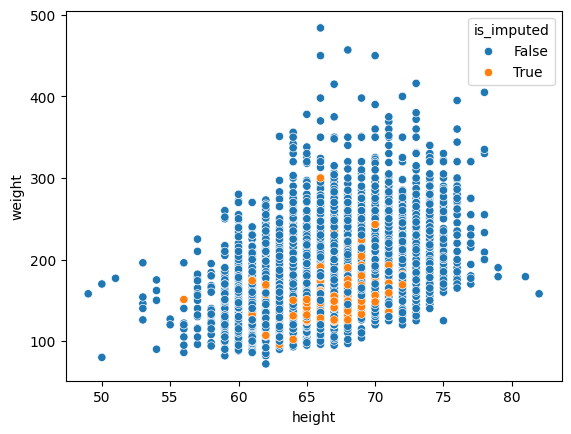

In [36]:
(
    pd.concat(
        [
            nhanes_df_knn,
            nhanes_df.missing.create_shadow_matrix(True, False, suffix= "_imp", only_missing=True)
        ],
        axis = 1
    )
    .missing.scatter_imputation_plot(
        x = "height",
        y = "weight"
    )
)

## Imputacion basada en modelos

In [37]:
nhanes_model_df = (
    nhanes_df
    .select_columns("height", "weight", "gender", "age")
    .sort_values(by= "height")
    .transform_column(
        "weight",
        lambda x: x.ffill(),
        elementwise = False
    )
    .missing.bind_shadow_matrix(
        True,
        False,
        suffix= "_imp",
        only_missing = False
    )
)

nhanes_model_df

d:\david\learning_platzi\dataScientistPython\datos_faltantes_imputacion\venv\Lib\site-packages\pandas_flavor\register.py:164: FutureWarning: This function will be deprecated in a 1.x release. Please use `jn.select` instead.
  return method(self._obj, *args, **kwargs)


,height,weight,gender,age,height_imp,weight_imp,gender_imp,age_imp
SEQN,,,,,,,,
94940.0,49.0,158.0,Female,80.0,False,False,False,False
97877.0,50.0,80.0,Female,29.0,False,False,False,False
96508.0,50.0,170.0,Female,46.0,False,False,False,False
102379.0,51.0,177.0,Female,71.0,False,False,False,False
95094.0,53.0,126.0,Female,37.0,False,False,False,False
...,...,...,...,...,...,...,...,...
102915.0,NaN,107.0,Female,14.0,True,False,False,False
102926.0,NaN,107.0,Female,15.0,True,False,False,False
102941.0,NaN,107.0,Female,14.0,True,False,False,False


In [38]:
height_ols = (
    nhanes_model_df
    .pipe(
        lambda df: smf.ols( "height ~  weight + gender + age", data = df)
        .fit()
    )
)

In [39]:
ols_imputed_values = (
    nhanes_model_df
    .pipe(
        lambda df: df[df.height.isna()]
    )
    .pipe(
        lambda df: height_ols.predict(df).round()
    )
)

ols_imputed_values

SEQN
93707.0     69.0
93719.0     64.0
93733.0     64.0
93736.0     69.0
93737.0     69.0
            ... 
102915.0    63.0
102926.0    63.0
102941.0    63.0
102945.0    68.0
102955.0    63.0
Length: 1669, dtype: float64

In [40]:
nhanes_model_df.loc[nhanes_model_df.height.isna(), ["height"]] = ols_imputed_values
nhanes_model_df

,height,weight,gender,age,height_imp,weight_imp,gender_imp,age_imp
SEQN,,,,,,,,
94940.0,49.0,158.0,Female,80.0,False,False,False,False
97877.0,50.0,80.0,Female,29.0,False,False,False,False
96508.0,50.0,170.0,Female,46.0,False,False,False,False
102379.0,51.0,177.0,Female,71.0,False,False,False,False
95094.0,53.0,126.0,Female,37.0,False,False,False,False
...,...,...,...,...,...,...,...,...
102915.0,63.0,107.0,Female,14.0,True,False,False,False
102926.0,63.0,107.0,Female,15.0,True,False,False,False
102941.0,63.0,107.0,Female,14.0,True,False,False,False


<Axes: xlabel='weight', ylabel='height'>

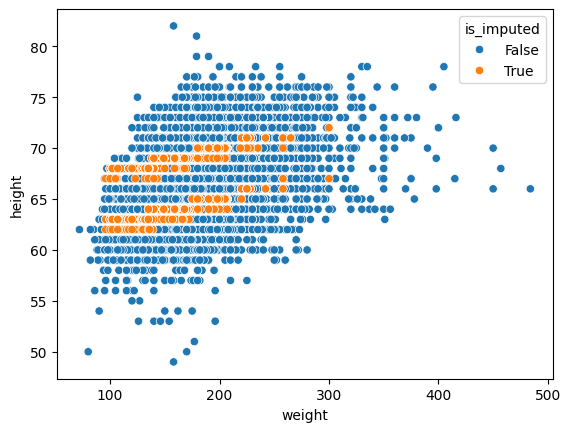

In [41]:
(
    nhanes_model_df
    .missing.scatter_imputation_plot(
        x = "weight",
        y = "height"
    )
)

## Imputaciones multiples por ecuaciones encadenadas (MICE)

<Axes: xlabel='height', ylabel='weight'>

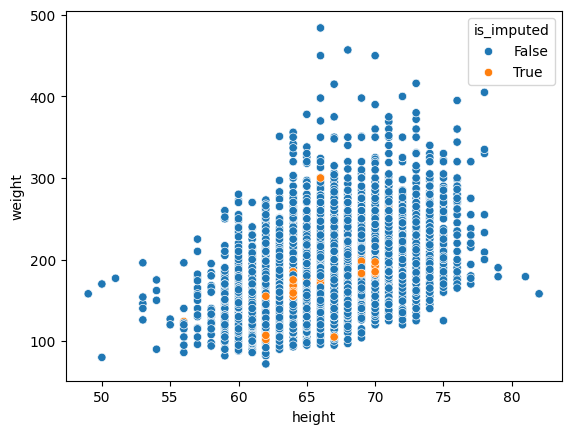

In [46]:
mice_imputer = sklearn.impute.IterativeImputer(
    estimator= BayesianRidge(),
    initial_strategy="mean",
    imputation_order="ascending",
)

nhanes_mice_df = nhanes_transformed_df.copy(deep=True)
nhanes_mice_df.iloc[:, :] = mice_imputer.fit_transform(nhanes_transformed_df).round()

nhanes_mice_df = pd.concat(
    [
        nhanes_mice_df,
        nhanes_df.missing.create_shadow_matrix(True, False, suffix= "_imp")
    ]
)

nhanes_mice_df.missing.scatter_imputation_plot(
    x= "height",
    y= "weight"
)

#### Transformacion inversa de los datos